In [0]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
print(torch.cuda.is_available())

True


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!unzip '/content/gdrive/My Drive/cityscape/leftImg8bit_trainvaltest.zip' -d '/content/gdrive/My Drive/cityscape/'

In [0]:
#!unzip '/content/gdrive/My Drive/cityscape/gtFine_trainvaltest.zip' -d '/content/gdrive/My Drive/cityscape/'
#!find '/content/gdrive/My Drive/cityscape/gtFine/train' -type f | wc -l
#!find '/content/gdrive/My Drive/cityscape/leftImg8bit/train' -type f | wc -l

# Dataset and Dataloader 

In [0]:
#transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=1), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trans1 = transforms.Compose([transforms.Resize((572,572)), transforms.ToTensor()])
trans2 = transforms.Compose([transforms.Resize((388,388)), transforms.ToTensor()])

trainset = torchvision.datasets.Cityscapes(root='/content/gdrive/My Drive/cityscape', split='train',mode='fine',
                                           target_type='semantic', transform=trans1, target_transform=trans2)

#trainset2 = torchvision.datasets.Cityscapes(root='./data', train=True,
#                                        download=True, transform=transform2)

#tset = ConcatDataset((trainset, trainset2))
tloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)




# Model


In [0]:
import torch.nn as nn

import torch
import numpy as np
import torch.nn.functional as F

from torch.autograd import Variable


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 0), nn.ReLU())
            self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 0), nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))
      
      
class unet(nn.Module):
    def __init__(
        self, feature_scale=1, n_classes=35, is_deconv=True, in_channels=3, is_batchnorm=True
    ):
        super(unet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [32, 64, 256, 512, 512]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)
        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)

        return final

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = unet()
model.to(device)

unet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, p

# Optimizer

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

# Debugging Model

tensor(1.2736, device='cpu', grad_fn=<NllLoss2DBackward>)
torch.Size([6, 35, 388, 388])
(388, 388)


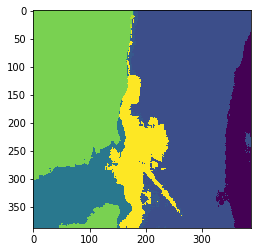

[[21 21 21 ... 11 11 11]
 [21 21 21 ... 11 11 11]
 [21 21 21 ... 11 11 11]
 ...
 [ 7  7  7 ...  1  1  1]
 [ 7  7  7 ...  1  1  1]
 [ 7  7  7 ...  1  1  1]]
[ 1  6  7  8 11 21 23 26]


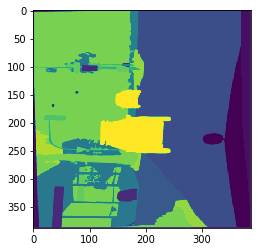

In [0]:
model.to("cpu")
import torch.nn.functional as F
import matplotlib.pyplot as plt

d = iter(tloader)
x,y = d.next()
y=y*255
y=y.type(torch.LongTensor)
#print(x.shape)
y=y.squeeze(dim=1)
#print(x)
#print(y)

#
#img2=trainset[0][0]
#img2=img2[None,:,:,:]

out= model(x)
#print(out)
#F.interpolate(input, size=(572,572), mode="bilinear", align_corners=True)
#lab = trainset[0][1]
#lab = lab.squeeze(dim=1)
#lab = lab.type(torch.LongTensor)
loss2=criterion(out,y)
out=out*255
print(loss2)
print(out.shape)
out=out[0]
out2 = out.detach().numpy()
out2 = np.argmax(out2,axis=0)
print(out2.shape)
plt.imshow(np.transpose(out2))
plt.show()
print(out2)
print(np.unique(out2))
y=y[0]
y = y.detach().numpy()
y = np.squeeze(y)
plt.imshow(np.transpose(y))
plt.show()
#print(torch.argmax(out, dim=1).shape)
#out2 = out.detach().numpy()
#out3 = np.argmax(out2,axis=1)
#out3 = np.squeeze(out3)
#print(out2.shape)
#print(out3.shape)
#print(out3)
#print(np.unique(out3))
#print(np.unique(y.numpy()))

**blah**



In [0]:
import matplotlib.pyplot as plt
import PIL
img, label = iter(tloader).next()
print(criterion(img,label))
img = img[0,:,:,:]
label = label[0,0,:,:]

print(img.shape)
print(label.shape)
print(img)

img = img.numpy()
label = label.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
plt.imshow(label)
plt.show()
print(np.unique(label)*255)





RuntimeError: ignored

# Training Model

In [0]:
#model.to("cpu")
for epoch in range(3):
  running_loss = 0.0
  i=0;
  for data in tloader:
    x,y=data[0].to(device), (data[1].type(torch.LongTensor)).to(device)
    y.squeeze_(dim=1)
    y=y*255
    #y=y.type(torch.LongTensor)
    #y=y.to(device)
    output=model(x)
    loss=criterion(output,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 5 == 4:    # print every 275th mini-batch (275*5 total minis)
      print('[%d, %5d] loss: %.3f' %
      (epoch + 1, i + 1, running_loss/5))
      running_loss = 0.0
            
    i=i+1
print('Finished Training')

[1,     5] loss: 1.387
[1,    10] loss: 1.340
[1,    15] loss: 1.445
[1,    20] loss: 1.264
[1,    25] loss: 1.478
[1,    30] loss: 1.486
[1,    35] loss: 1.408
[1,    40] loss: 1.460
[1,    45] loss: 1.438
[1,    50] loss: 1.402
[1,    55] loss: 1.340
[1,    60] loss: 1.388
[1,    65] loss: 1.394
[1,    70] loss: 1.287
[1,    75] loss: 1.363
[1,    80] loss: 1.362
[1,    85] loss: 1.364
[1,    90] loss: 1.590
[1,    95] loss: 1.296
[1,   100] loss: 1.370
[1,   105] loss: 1.496
[1,   110] loss: 1.381
[1,   115] loss: 1.309
[1,   120] loss: 1.343
[1,   125] loss: 1.461
[1,   130] loss: 1.277
[1,   135] loss: 1.391
[1,   140] loss: 1.452
[1,   145] loss: 1.326
[1,   150] loss: 1.379
[1,   155] loss: 1.422
[1,   160] loss: 1.368
[1,   165] loss: 1.498
[1,   170] loss: 1.347
[1,   175] loss: 1.328
[1,   180] loss: 1.366
[1,   185] loss: 1.231
[1,   190] loss: 1.286
[1,   195] loss: 1.325
[1,   200] loss: 1.262
[1,   205] loss: 1.393
[1,   210] loss: 1.337
[1,   215] loss: 1.346
[1,   220] 

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/CityscapeUNet22.pth')

In [0]:
model.to("cuda")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
a,b=iter(tloader).next()
a=a.type(torch.cuda.FloatTensor)
b=b.type(torch.cuda.FloatTensor)
print(a,b)

tensor([[[[0.2745, 0.2902, 0.2745,  ..., 0.2627, 0.2549, 0.2980],
          [0.3098, 0.3020, 0.2549,  ..., 0.2667, 0.2510, 0.3020],
          [0.3255, 0.2941, 0.2431,  ..., 0.2745, 0.2549, 0.2980],
          ...,
          [0.2314, 0.2314, 0.2392,  ..., 0.2431, 0.2471, 0.2471],
          [0.2275, 0.2314, 0.2431,  ..., 0.2392, 0.2353, 0.2392],
          [0.2275, 0.2314, 0.2431,  ..., 0.2196, 0.2157, 0.2235]],

         [[0.3529, 0.3765, 0.3686,  ..., 0.3412, 0.3412, 0.4039],
          [0.3804, 0.3961, 0.3608,  ..., 0.3451, 0.3373, 0.4078],
          [0.4039, 0.3961, 0.3451,  ..., 0.3490, 0.3412, 0.4039],
          ...,
          [0.2980, 0.2980, 0.3020,  ..., 0.3098, 0.3059, 0.3098],
          [0.2941, 0.2980, 0.3020,  ..., 0.2941, 0.3020, 0.3020],
          [0.2941, 0.2980, 0.3020,  ..., 0.2784, 0.2824, 0.2824]],

         [[0.2784, 0.2941, 0.2941,  ..., 0.3137, 0.3020, 0.3608],
          [0.3137, 0.3294, 0.2941,  ..., 0.3137, 0.3059, 0.3686],
          [0.3412, 0.3373, 0.2863,  ..., 0

# Old spare


torch.Size([3, 36, 138])


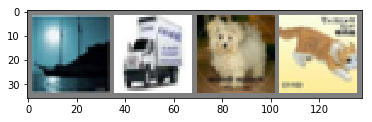

 ship truck   dog   cat
torch.Size([3, 36, 138])


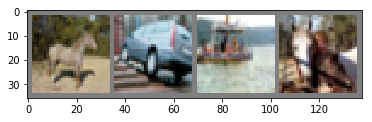

horse   car  ship horse
torch.Size([3, 36, 138])


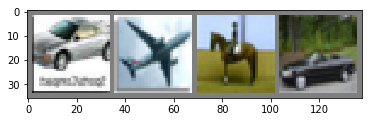

  car plane horse   car


In [0]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    print(img.shape)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(trainloader2)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

dataiter = iter(tloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
#nn.LocalResponseNorm(32, alpha=0.0001, beta=0.75, k=2.0)

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, padding=1),
            nn.LocalResponseNorm(32, alpha=0.0001, beta=0.75, k=2.0),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LocalResponseNorm(32, alpha=0.0001, beta=0.75, k=2.0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(2304, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )



    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


model = AlexNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
model.to(device)

cuda:0


AlexNet(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LocalResponseNorm(32, alpha=0.0001, beta=0.75, k=2.0)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LocalResponseNorm(32, alpha=0.0001, beta=0.75, k=2.0)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=

In [0]:
#model.conv1.weight.data.fill_(1)
#model.conv2.weight.data.fill_(0.6)
#model.conv3.weight.data.fill_(0.3)
#model.conv4.weight.data.fill_(0.7)
#model.conv5.weight.data.fill_(1)

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.000001, weight_decay=0.0005)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


In [0]:
for epoch in range(2):
  running_loss = 0.0
  i=0;
  for data in tloader:
    x,y=data[0].to(device), data[1].to(device)
    output=model(x)
    loss=criterion(output,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 90 == 89:    # print every 90 mini-batches (390 total minis)
      print('[%d, %5d] loss: %.3f' %
      (epoch + 1, i + 1, running_loss/90))
      running_loss = 0.0
            
    i=i+1
print('Finished Training')



RuntimeError: ignored

**Testing...**



torch.Size([3, 546, 274])


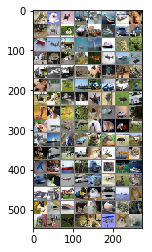

GroundTruth:   bird   cat   cat truck


In [0]:
dataiter = iter(trainloader)
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)
outputs = model(images)

torch.Size([128, 3, 32, 32])


In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird   dog   cat truck


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 82 %
Accuracy of  bird : 78 %
Accuracy of   cat : 57 %
Accuracy of  deer : 88 %
Accuracy of   dog : 65 %
Accuracy of  frog : 88 %
Accuracy of horse : 87 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/CityscapeUNet.pth')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/CityscapeUNet.pth'))


RuntimeError: ignored